In [141]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [215]:
class DataFetcher:
    """
    Class containing all methods required to fetch
    data for a given point in time.

    Is initialised with price and ratio data
    """
    def __init__(
            self,
            price_path: str='data/cleaned_prices.pkl',
            ratio_path: str='data/cleaned_ratios.pkl'
            ):
        self.prices = pd.read_pickle(price_path)
        self.ratios = pd.read_pickle(ratio_path)
        self.dates = pd.Series(self.ratios['date'].unique()
            ).sort_values().reset_index(drop=True)
        

    def _get_dates(self, date, number):
        """
        return pertinent dates
        """
        return self.dates.loc[self.dates<date].iloc[-number:]


    def _get_entries(self, entries, dates):
        """
        return data pertinent dates
        """
        # find all matching entries
        entries = entries.loc[entries['date'].isin(dates)].copy()

        # return companies with entries for all dates
        counts = entries['permno'].value_counts() >= len(dates)
        companies_to_keep = counts.loc[counts].index
        return entries.loc[entries['permno'].isin(companies_to_keep)]


    def _match_entries(self, prices, ratios):
        """
        match data such that only entries from dates where
        all requested financial and price data is available
        """
        companies_to_keep = prices.loc[prices['permno'].isin(ratios['permno']), 'permno'].unique()
        prices = prices.loc[prices['permno'].isin(companies_to_keep)]
        ratios = ratios.loc[ratios['permno'].isin(companies_to_keep)]
        return prices, ratios


    def _get_data(self, date, n_prices, n_ratios):
        """
        wrap all data fetching for specific date
        """
        price_dates = self._get_dates(
            date=date,
            number=n_prices)

        _prices = self._get_entries(
            entries=self.prices,
            dates=price_dates)

        ratio_dates = self._get_dates(
            date=date,
            number=n_ratios)

        _ratios = self._get_entries(
            entries=self.ratios,
            dates=ratio_dates)

        _prices, _ratios = self._match_entries(
            prices=_prices,
            ratios=_ratios)

        return _prices, _ratios


class BackTester(DataFetcher):
    def __init__(self):
        DataFetcher.__init__(self)
        self.returns = self.prices.pivot(
            index='date',
            values='ret',
            columns='permno')


    def _results(self):
        """
        function calculating results given allocations
        """
        portfolio_returns = []
        for _, data in self.investments.iterrows():
            # get pertinent return data
            _returns = self.returns.loc[
                (data['buy_date']<self.returns.index) & (self.returns.index<=data['sell_date']), data['allocs'].index]
            # multiply by allocations
            _returns = _returns.multiply(data['allocs'])
            # get sum + 1 (portfolio return)
            _returns = _returns.sum(axis=1) + 1
            portfolio_returns.append(_returns)
        # return series of returns over all periods
        return pd.concat(portfolio_returns)


    def rolling_test(
            self,
            decision_function,
            n_prices=1,
            n_ratios=1,
            frequency=1
            ):
        """
        main backtesting function, fetches data at
        desired frequency, investment strategy and
        returns allocations given strategy
        """
        investments = pd.Series(dtype='object')
        # jump ahead in dates to allow lookback
        _dates = self.dates.iloc[max(n_prices, n_ratios):]
        # loop over dates
        for _date in tqdm(_dates[::frequency]):
            # get data for date
            _prices, _ratios = self._get_data(
                date=_date,
                n_prices=n_prices,
                n_ratios=n_ratios)
            # get investments for date
            investments.loc[_date] = decision_function(
                prices=_prices,
                ratios=_ratios)
            self._test_prices = _prices
            self._test_ratios = _ratios
        # cleaning data, specifying dates etc
        investments = pd.DataFrame(investments, columns=['allocs'])
        investments['buy_date'] = investments.index
        investments['sell_date'] = investments['buy_date'].shift(-1)
        investments = investments.dropna()
        self.investments = investments
        self.results = self._results()

    def analyse(self):
        try:
            _returns = self.results-1
        except NameError:
            print('Unable to analyse results, has backtest been run?')

        metrics = pd.Series({
            'Mean returns' : _returns.mean(),
            'Standard deviation' : _returns.std(),
            'Sharpe' : _returns.mean() / _returns.std(),
            'Skew' : _returns.skew(),
            'Kurtosis' : _returns.kurtosis()
        })

        metrics = metrics.round(3)

        print(metrics)

In [216]:
# EXAMPLE STRATEGIES

def mock_decision(prices, ratios):
    return pd.Series({prices['permno'].iloc[0]:.5, prices['permno'].iloc[-1]:.5})

def easy_momentum(prices, ratios, count=50):
    returns = prices.pivot(index='date', values='ret', columns='permno') + 1
    period_returns = returns.cumprod().iloc[-1]
    top_stocks = period_returns.nlargest(count).index
    return pd.Series({stock:1/len(top_stocks) for stock in list(top_stocks)})

def entire_market(prices, ratios):
    all_stocks = prices['permno'].unique()
    return pd.Series({s:1/len(all_stocks) for s in all_stocks})

100%|██████████| 395/395 [00:02<00:00, 185.56it/s]


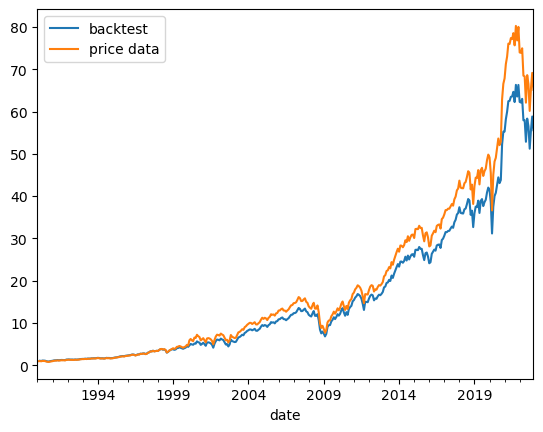

In [217]:
# SANITY TEST
# COMPARE ENTIRE MARKET STRATEGY TO SIMPLE CALCULATIONS ON THE PRICES DATA

backtester = BackTester()
backtester.rolling_test(decision_function=entire_market, n_prices=1, frequency=1)

prices = pd.read_pickle('data/cleaned_prices.pkl')
prices = (prices.pivot(columns='permno', index='date', values='ret').mean(axis=1) + 1).cumprod()


fig, ax = plt.subplots()
backtester.results.cumprod().plot(ax=ax, label='backtest')
prices.plot(ax=ax, label='price data')
ax.legend()

# performs slightly worse ?? still passes the sanity test imo.
# probably missing price or financial data for some stocks 
# which end up getting taken out by DataFetcher

In [218]:
backtester.analyse()

Mean returns          0.012
Standard deviation    0.054
Sharpe                0.217
Skew                  0.132
Kurtosis              3.383
dtype: float64
